In [1]:
import os
import pandas as pd
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms.functional as tx
import torchvision.transforms as T
import numpy as np
from torch import nn
from torchmetrics import Accuracy
from PIL import Image
import random

In [2]:
few_data = False
data_num = 100
batch_size = 10

In [3]:
class_map=['A10', 'A400M', 'AG600', 'AV8B', 'B1', 'B2', 'B52', 'Be200', 'C130', 'C17', 'C5', 'E2', 'EF2000', 'F117', 'F14', 'F15', 'F16', 'F18', 'F22', 'F35', 'F4', 'J20', 'JAS39', 'Mig31', 'Mirage2000', 'MQ9', 'Rafale', 'RQ4', 'SR71', 'Su34', 'Su57', 'Tornado', 'Tu160', 'Tu95', 'U2', 'US2', 'V22', 'Vulcan', 'XB70', 'YF23']

In [17]:
global_mean = [120.74446532507794, 129.82000781821228, 138.8076694793008]
global_std = [51.8159762582478, 51.42346227240079, 52.72563864069662]

In [20]:
class MyDataset():
    def __init__(self, csv_file, augment=False):
        if few_data:
            self.df = pd.read_csv(csv_file).iloc[:data_num]
        else:
            self.df = pd.read_csv(csv_file)
        self.image_size=256
        self.mean = np.array(global_mean, dtype=np.float32)
        self.std = np.array(global_std, dtype=np.float32)
        self.augment = augment
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.df["type"][idx]
        image_name = self.df["name"][idx]
#         path = 
        image = cv2.imread("../data/militaryaircraftdetectiondataset/crop/"+class_map[label]+"/"+image_name)
        image = cv2.resize(image, dsize=(self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.augment:
            image = augmentation(image)
        image = tx.to_tensor(image)
        image = tx.resize(image, (self.image_size, self.image_size))
        image = tx.normalize(image, self.mean/255, self.std/255) 
#         image = tx.to_tensor(image)
        return image, label

In [27]:
def augmentation(image):
    #color jitter
    if(random.random()>0.5):
        jitter = T.ColorJitter(brightness=.5, hue=.3)
        image = jitter(image)



    #Gaussian blur
    if(random.random()>0.5):
        blurrer = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        image = blurrer(image)



    #Perspective
    if(random.random()>0.5):
        perspective_transformer = T.RandomPerspective(distortion_scale=0.6, p=1.0)
        image = perspective_transformer(image)


    #Rotation
    if(random.random()>0.5):
        random_degree = random.randint(0, 8) * 45
        image = tx.rotate(image, random_degree)




    #Affine
    if(random.random()>0.5):
        affine_transfomer = T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))
        image = affine_transfomer(image)



    #Invert
    if(random.random()>0.5):
        inverter = T.RandomInvert()
        image = inverter(image)

    #Posterize
    if(random.random()>0.5):
        posterizer = T.RandomPosterize(bits=2)
        image = posterizer(image)



    #Solarize
    if(random.random()>0.5):
        solarizer = T.RandomSolarize(threshold=192.0)
        image = solarizer(image)


    #AdjustSharpness
    if(random.random()>0.5 ):
        sharpness_adjuster = T.RandomAdjustSharpness(sharpness_factor=1)
        image = sharpness_adjuster(image)



    #Equalize
    if(random.random()>0.5):
        equalizer = T.RandomEqualize()
        image = equalizer(image)
        
    if(random.random()>0.5):
        cropper = T.RandomCrop(size=(128, 128))
        image = cropper(image) 


    return image

In [28]:
train_dataset = MyDataset("../data/train_data", augment=True)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
valid_dataset = MyDataset("../data/valid_data")
valid_dataloader = DataLoader(valid_dataset,batch_size=batch_size)
test_dataset = MyDataset("../data/test_data")
test_dataloader = DataLoader(test_dataset,batch_size=batch_size)

In [40]:
image, label = next(iter(train_dataloader))
# plt.imshow(image[0])
# print(label)
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

9708
2774
1387


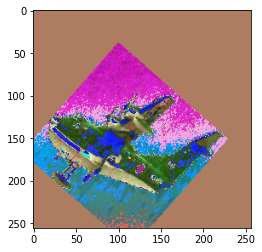

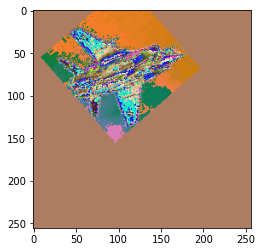

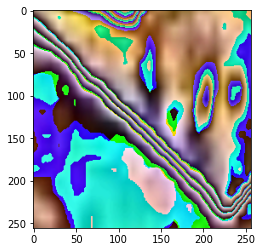

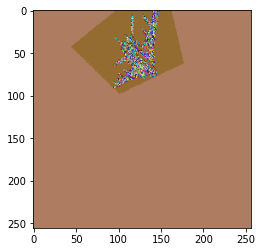

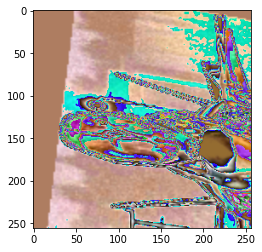

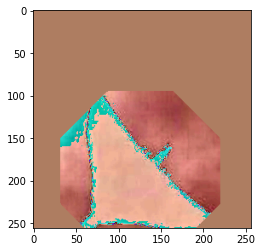

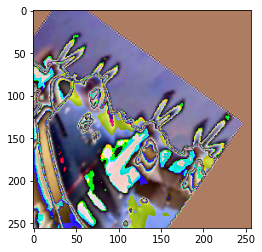

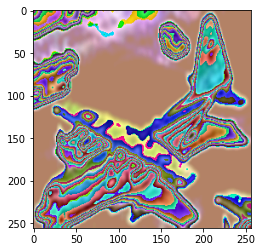

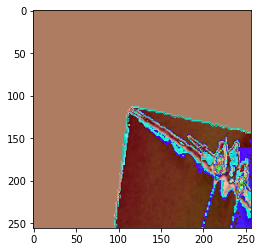

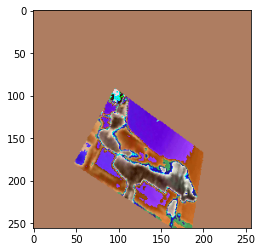

In [41]:
transform = T.ToPILImage()
for i in range(10):
    img = transform(image[i])
    plt.imshow(img)
    plt.show()
    


In [42]:
model = torchvision.models.efficientnet_b6(pretrained=True)
model.classifier = torch.nn.Linear(2304, 40, bias=True)

In [51]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
loss_fn = nn.CrossEntropyLoss()
criterion = Accuracy(task="multiclass", num_classes=40).to(device)
origin_lr = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=origin_lr)

print(device)

cuda


In [52]:
def get_score(pred, label):
    pred = torch.argmax(pred, axis = 1)
    score = 0
    for i in range(len(pred)):
        if pred[i]==label[i]:
            score+=1

    return score

In [53]:

def train(dataloader, optimizer, loss_fn, model):
    model.train()
    total_loss = 0
    total_acc = 0
    for i, (image, label) in enumerate(dataloader):
        image = image.to(device)
        label = label.to(device)
        
        image = image.requires_grad_()
        pred = model(image)
        loss = loss_fn(pred, label)
        acc = get_score(pred, label)
        total_loss += loss.item()
        total_acc += acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%200==0:
            print("train average total loss : ", total_loss/(i+1))
    return total_loss, total_acc
def valid(dataloader, loss_fn, model):
    model.eval()
    total_loss = 0
    total_acc = 0
    for i, (image, label) in enumerate(dataloader):
        image = image.to(device)
        label = label.to(device)
        pred = model(image)
        loss = loss_fn(pred, label)
        acc = get_score(pred, label)
        total_loss += loss.item()
        total_acc += acc
        if i%200==0:
            print("valid average total loss : ", total_loss/(i+1))
    return total_loss, total_acc

In [ ]:
model = model.to(device)
max_score = 0
if not os.path.exists("../data/models"):
    os.mkdir("../data/models")
for i in range(100):
    print("epoch : ", i)
    train_loss, train_acc = train(train_dataloader, optimizer, loss_fn, model)
    print("train epoch loss : ",train_loss/len(train_dataloader))
    print("train epoch acc : ",train_acc/len(train_dataset))
    with torch.no_grad():
        valid_loss, valid_acc = valid(valid_dataloader, loss_fn, model)
        print("valid epoch loss : ",valid_loss/len(valid_dataloader))
        print("valid epoch acc : ",valid_acc/len(valid_dataset))
        if valid_acc/len(valid_dataset)>max_score:
            max_score = valid_acc/len(valid_dataset)
            torch.save(model.state_dict(), "../data/models/best.pth")
            print("###############save best model####################")

epoch :  0
train average total loss :  0.3489343225955963
train average total loss :  0.35076668165494984
train average total loss :  0.34644996961226
train average total loss :  0.3431599716231556
train average total loss :  0.34105502090871537
train epoch loss :  0.3396546782944578
train epoch acc :  0.9048207663782447
valid average total loss :  0.00966731272637844
valid average total loss :  0.303597183967399
valid epoch loss :  0.2940945662074419
valid epoch acc :  0.9455659697188176
###############save best model####################
epoch :  1
train average total loss :  0.2525348365306854
train average total loss :  0.32352225227305775
train average total loss :  0.32837148261059973
train average total loss :  0.330603626610108
train average total loss :  0.3255041639339664
train epoch loss :  0.3174925868802099
train epoch acc :  0.9085290482076638
valid average total loss :  0.003333447966724634
valid average total loss :  0.3061651378660305
valid epoch loss :  0.2916103461601

In [18]:
def test(dataloader, loss_fn,model):
    model.eval()
    total_loss = 0
    total_acc = 0
    for i, (image, label) in enumerate(dataloader):
        image = image.to(device)
        label = label.to(device)
        pred = model(image)
        acc = get_score(pred, label)
        loss = loss_fn(pred, label)
        total_loss += loss.item()
        total_acc += acc
        if i%200==0:
            print("test average total loss : ", total_loss/(i+1))
    return total_loss, total_acc

In [19]:
test_loss, test_acc = test(test_dataloader, loss_fn, model)
print(test_loss/len(test_dataloader), test_acc/len(test_dataset))



test average total loss :  0.0709834098815918
0.45107248311957826 0.8875270367700072
